In [5]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
raw_train = pd.read_csv('data/train.csv')
raw_test = pd.read_csv('data/test.csv')
print raw_train.shape
print raw_train.head()

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2 

In [175]:
# get columns with too many (>10%) null values
nas = raw_train.isnull().sum()
nas_nulls = nas[nas>raw_train.shape[0]/10]
print "Train columns that should be removed\n",nas_nulls

nast = raw_test.isnull().sum()
nast_nulls = nast[nast>raw_test.shape[0]/10]
print "Test columns that should be removed\n",nast_nulls
nancols = nas_nulls.index.tolist()

Train columns that should be removed
LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64
Test columns that should be removed
LotFrontage     227
Alley          1352
FireplaceQu     730
PoolQC         1456
Fence          1169
MiscFeature    1408
dtype: int64


In [132]:
processed_data = raw_train.drop(set(nancols),1)
processed_data = processed_data.drop('Id',1)
test_processed = raw_test.drop(set(nancols),1)
test_processed = test_processed.drop('Id',1)

In [223]:
# first quickly pick out columns with integer types
types = processed_data.dtypes
ints = types[types == 'int64'].index.tolist()
numericals = processed_data[ints]

test_numericals = test_processed[numericals.columns[:-1]].fillna(test_numericals.mean())

In [224]:
print numericals.shape
print test_numericals.shape

(1460, 34)
(1459, 33)


In [225]:
tmp = numericals.as_matrix()
tmpt = test_numericals.as_matrix()

In [196]:
x = tmp[:,:-1]
y = tmp[:,-1]/1000

In [226]:
x_normed = x #(x - x.mean(axis=0))/x.std(axis=0)
test_normed = tmpt #(tmpt - tmpt.mean(axis=0))/tmpt.std(axis=0)
print x_normed
print "==="
print test_normed

[[   60  8450     7 ...,     0     2  2008]
 [   20  9600     6 ...,     0     5  2007]
 [   60 11250     7 ...,     0     9  2008]
 ..., 
 [   70  9042     7 ...,  2500     5  2010]
 [   20  9717     5 ...,     0     4  2010]
 [   20  9937     5 ...,     0     6  2008]]
===
[[  2.00000000e+01   1.16220000e+04   5.00000000e+00 ...,   0.00000000e+00
    6.00000000e+00   2.01000000e+03]
 [  2.00000000e+01   1.42670000e+04   6.00000000e+00 ...,   1.25000000e+04
    6.00000000e+00   2.01000000e+03]
 [  6.00000000e+01   1.38300000e+04   5.00000000e+00 ...,   0.00000000e+00
    3.00000000e+00   2.01000000e+03]
 ..., 
 [  2.00000000e+01   2.00000000e+04   5.00000000e+00 ...,   0.00000000e+00
    9.00000000e+00   2.00600000e+03]
 [  8.50000000e+01   1.04410000e+04   5.00000000e+00 ...,   7.00000000e+02
    7.00000000e+00   2.00600000e+03]
 [  6.00000000e+01   9.62700000e+03   7.00000000e+00 ...,   0.00000000e+00
    1.10000000e+01   2.00600000e+03]]


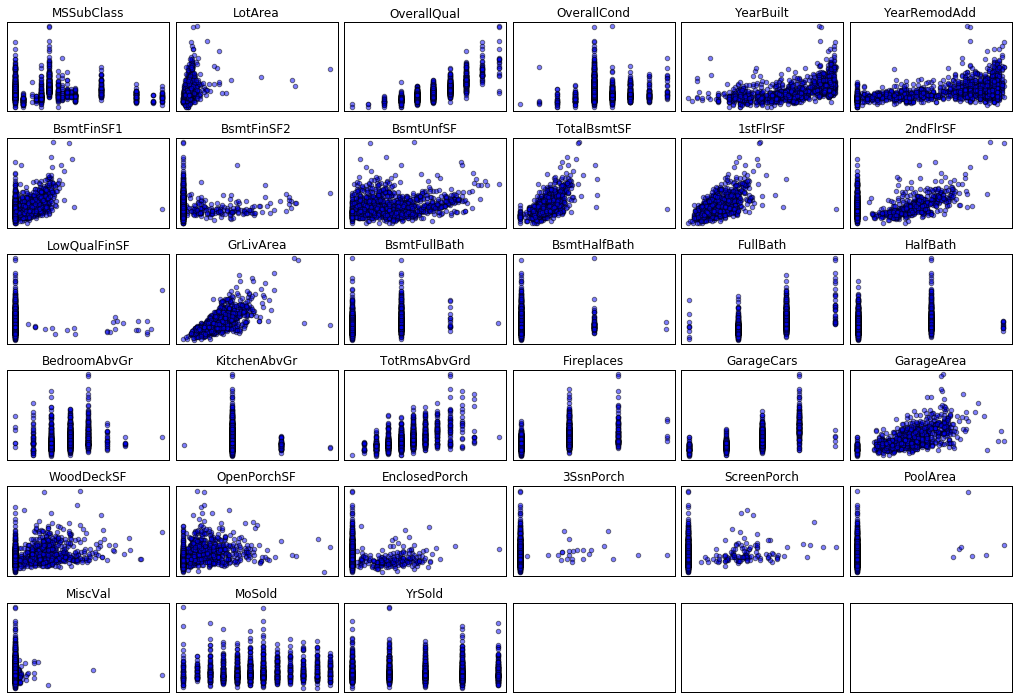

In [198]:
f, axarr = plt.subplots(6,6, figsize=(18,12))
plt.subplots_adjust( hspace=0.3 )
plt.subplots_adjust( wspace=0.04 )
counter = 0
for i in range(6):
    for j in range(6):
        axarr[i][j].get_yaxis().set_ticks([])
        axarr[i][j].get_xaxis().set_ticks([])
        if counter >= numericals.shape[1]-1:
            continue
        else:
            axarr[i][j].scatter(x_normed[:,counter], y,alpha=0.5)
            axarr[i][j].set_title(numericals.columns[counter])
            counter += 1

In [109]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold

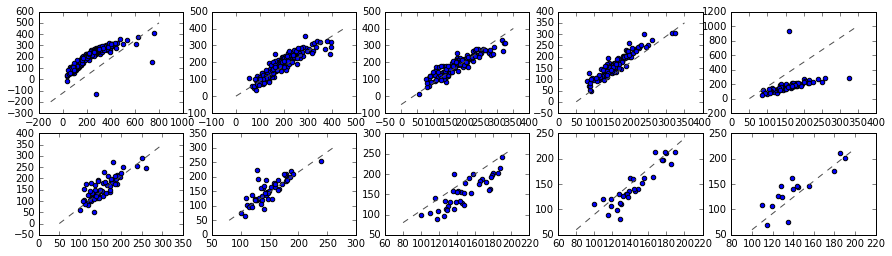

In [245]:
x_train, x_test, y_train, y_test = train_test_split(x_normed, y, test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

lr = linear_model.LinearRegression()
lr.fit(x_train,y_train.ravel().T)


times=1

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

In [228]:
print test_normed[660:670,:1]

[[ 20.]
 [ 50.]
 [ 30.]
 [ 50.]
 [ 70.]
 [ 50.]
 [ 60.]
 [ 50.]
 [ 30.]
 [ 70.]]


In [236]:
pred_t = lr.predict(test_normed)
print pred_t
output = raw_test[['Id']]
output['SalePrice']=pred_t*1000

[ 132.45345247  177.09282497  185.8374763  ...,  176.77305257  103.88542589
  257.99673112]


C:\Users\d\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [239]:
print output.head()
output.to_csv("prediction.csv",index=False)

     Id      SalePrice
0  1461  132453.452465
1  1462  177092.824968
2  1463  185837.476301
3  1464  205786.183488
4  1465  202581.214680
